# Wind Downscaling


In [1]:
import os
from datetime import date, datetime
from pathlib import Path

from dotenv import load_dotenv

from data.data_generator import BatchGenerator, NaiveDecoder, LocalFileProvider, S3FileProvider
from gan import train, metrics
load_dotenv()
import numpy as np
import tensorflow as tf
import tensorflow.keras.callbacks as cb
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
import pandas as pd

Num GPUs Available: 0


## Set configuration

In [2]:
DATA_ROOT = Path('/Volumes/Extreme SSD/data')
ERA5_DATA_FOLDER = DATA_ROOT / 'ERA5'
COSMO1_DATA_FOLDER = DATA_ROOT / 'COSMO1'
DEM_DATA_FILE = DATA_ROOT / 'dem/Switzerland-90m-DEM.tif'
PROCESSED_DATA_FOLDER = DATA_ROOT / 'img_prediction_files'
DATA_ROOT.mkdir(parents=True, exist_ok=True)
ERA5_DATA_FOLDER.mkdir(exist_ok=True)
COSMO1_DATA_FOLDER.mkdir(exist_ok=True)
DEM_DATA_FILE.parent.mkdir(exist_ok=True)
PROCESSED_DATA_FOLDER.mkdir(exist_ok=True)
cosmoblurred = True
run_id=datetime.now().strftime('%Y%m%d_%H%M')
data_provider = 'local'

In [3]:
# Start and end date for the data - should be in the 2016-2020 range
START_DATE = date(2017,1,1)
END_DATE = date(2017,3,31)
NUM_DAYS = (END_DATE-START_DATE).days + 1
# Number of consecutive images to form a sequence
SEQUENCE_LENGTH = 3
# Size of the high resolution image to be produced
IMG_SIZE = 64
# Number of sequences per batch
BATCH_SIZE = 8
# Number of noise channels to add to the image
NOISE_CHANNELS = 20

In [4]:
TOPO_PREDICTORS = ['tpi_500', 'slope', 'aspect']
HOMEMADE_PREDICTORS = ['e_plus', 'e_minus', 'w_speed', 'w_angle']
ERA5_PREDICTORS_SURFACE = ['u10', 'v10', 'blh', 'fsr', 'sp', 'sshf']
ERA5_PREDICTORS_Z500 = ['z']
if cosmoblurred:
    ALL_INPUTS = ['U_10M', 'V_10M'] #+ HOMEMADE_PREDICTORS + TOPO_PREDICTORS
    input_pattern = 'x_cosmo_{date}.nc'
    run_id = f'{run_id}_cosmo_blurred'
else:
    ALL_INPUTS = ERA5_PREDICTORS_Z500 + ERA5_PREDICTORS_SURFACE + TOPO_PREDICTORS + HOMEMADE_PREDICTORS
    input_pattern = 'x_{date}.nc'
ALL_INPUTS = ['U_10M', 'V_10M']
ALL_OUTPUTS = ['U_10M', 'V_10M']
BATCH_WORKERS = os.cpu_count()
if data_provider == 'local':
    input_provider = LocalFileProvider(PROCESSED_DATA_FOLDER, input_pattern)
    output_provider = LocalFileProvider(PROCESSED_DATA_FOLDER, 'y_{date}.nc')
elif data_provider == 's3':
    input_provider = S3FileProvider('wind-downscaling', 'img_prediction_files', pattern=input_pattern)
    output_provider = S3FileProvider('wind-downscaling', 'img_prediction_files', pattern='y_{date}.nc')
else:
    raise ValueError(f'Wrong value for data provider {data_provider}: please choose between s3 and local')
AVAIL_DATES = [pd.to_datetime(v) for v in
               set(input_provider.available_dates).intersection(output_provider.available_dates)]
START_DATE = min(AVAIL_DATES)
END_DATE = max(AVAIL_DATES)
batch_gen = BatchGenerator(input_provider, output_provider,
                                    decoder=NaiveDecoder(normalize=True),
                                    sequence_length=SEQUENCE_LENGTH,
                                    patch_length_pixel=IMG_SIZE, batch_size=BATCH_SIZE,
                                    input_variables=ALL_INPUTS,
                                    output_variables=ALL_OUTPUTS,
                                    start_date=START_DATE, end_date=END_DATE,
                                    num_workers=BATCH_WORKERS)
INPUT_CHANNELS = len(ALL_INPUTS)
OUT_CHANNELS = len(ALL_OUTPUTS)

In [5]:
inputs = []
outputs = []
with batch_gen as batch:
    for b in range(NUM_DAYS):
        print(f'Creating batch {b+1}/{NUM_DAYS}')
        x, y = next(batch)
        inputs.append(x)
        outputs.append(y)
inputs = np.concatenate(inputs, axis=0)
outputs = np.concatenate(outputs, axis=0)
print(f"Inputs: {inputs.shape}")
print(f"Outputs: {outputs.shape}")

Creating batch 1/90
Creating batch 2/90
Creating batch 3/90
Creating batch 4/90
Creating batch 5/90
Creating batch 6/90
Creating batch 7/90
Creating batch 8/90
Creating batch 9/90
Creating batch 10/90
Creating batch 11/90
Creating batch 12/90
Creating batch 13/90
Creating batch 14/90
Creating batch 15/90
Creating batch 16/90
Creating batch 17/90
Creating batch 18/90
Creating batch 19/90
Creating batch 20/90
Creating batch 21/90
Creating batch 22/90
Creating batch 23/90
Creating batch 24/90
Creating batch 25/90
Creating batch 26/90
Creating batch 27/90
Creating batch 28/90
Creating batch 29/90
Creating batch 30/90
Creating batch 31/90
Creating batch 32/90
Creating batch 33/90
Creating batch 34/90
Creating batch 35/90
Creating batch 36/90
Creating batch 37/90
Creating batch 38/90
Creating batch 39/90
Creating batch 40/90
Creating batch 41/90
Creating batch 42/90
Creating batch 43/90
Creating batch 44/90
Creating batch 45/90
Creating batch 46/90
Creating batch 47/90
Creating batch 48/90
C

In [6]:
INPUT_CHANNELS = len(ALL_INPUTS)
OUT_CHANNELS = len(ALL_OUTPUTS)

In [7]:
from gan.models import make_generator, make_discriminator
from gan.ganbase import  GAN
from data.data_generator import FlexibleNoiseGenerator

generator = make_generator(image_size=IMG_SIZE, in_channels=INPUT_CHANNELS,
                           noise_channels=NOISE_CHANNELS, out_channels=OUT_CHANNELS,
                           n_timesteps=SEQUENCE_LENGTH)
print(f"Generator: {generator.count_params():,} weights")

discriminator = make_discriminator(low_res_size=IMG_SIZE, high_res_size=IMG_SIZE, low_res_channels=INPUT_CHANNELS,
                                   high_res_channels=OUT_CHANNELS, n_timesteps=SEQUENCE_LENGTH)
print(f"Discriminator: {discriminator.count_params():,} weights")

noise_shape = (BATCH_SIZE, SEQUENCE_LENGTH, IMG_SIZE, IMG_SIZE, NOISE_CHANNELS)
gan = GAN(generator, discriminator, noise_generator=FlexibleNoiseGenerator(noise_shape, std=0.1), n_critic=3)

print(f"Total: {gan.generator.count_params() + gan.discriminator.count_params():,} weights")

Generator: 1,787,474 weights
Discriminator: 3,304,713 weights
Total: 5,092,187 weights


In [8]:
gan.compile(generator_optimizer=train.generator_optimizer(),
            generator_metrics= [tf.keras.metrics.RootMeanSquaredError(), metrics.LogSpectralDistance(),
                                metrics.WeightedRMSEForExtremes(), metrics.WindSpeedWeightedRMSE(),
                                metrics.SpatialKS(), metrics.AngularCosineDistance()],
            discriminator_optimizer=train.discriminator_optimizer(),
                discriminator_loss=train.discriminator_loss,
           metrics = [metrics.discriminator_score_fake(), metrics.discriminator_score_real()])

In [9]:
checkpoint_path_weights = Path('./checkpoints/gan') / run_id / 'weights-{epoch:02d}.ckpt'
checkpoint_path_weights.parent.mkdir(exist_ok=True, parents=True)
log_path = Path('./logs/gan') / run_id
if log_path.exists():
    log_path_str = str(log_path)
    !rm -rf {log_path_str}

In [10]:
%load_ext tensorboard
%tensorboard --logdir=$log_path

In [11]:
import matplotlib.pyplot as plt
def show(images, dims=1, legends=None):
    fig, axes = plt.subplots(ncols= len(images), figsize=(10, 10))
    for ax, im in zip(axes, images):
        for i in range(dims):
            label = legends[i] if legends is not None else ''
            ax.imshow(im[0, :, :, i], cmap='jet')
            ax.set_title(label)
            ax.axis('off')
    plt.show()
    return fig

In [12]:
class ShowCallback(tf.keras.callbacks.Callback):
    def __init__(self, dims):
        self.dims = dims
        
    def on_epoch_begin(self, epoch, logs):
        noise = FlexibleNoiseGenerator(noise_shape, std=0.1)
        show(self.model.generator([inputs[:self.dims], noise(self.dims)]))

In [13]:
callbacks = [
        cb.TensorBoard(log_path, write_images=True, update_freq='batch'),
        cb.ProgbarLogger('steps'),
        cb.TerminateOnNaN(),
        cb.ModelCheckpoint(str(checkpoint_path_weights), save_best_only=False, period=10,
                           save_weights_only=True),
        ShowCallback(3),
    ]

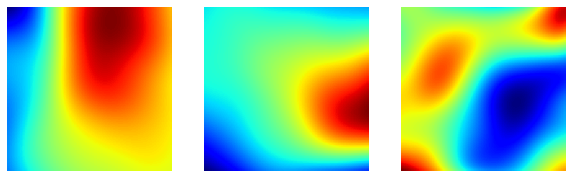

In [14]:
fig = show(inputs[:3])

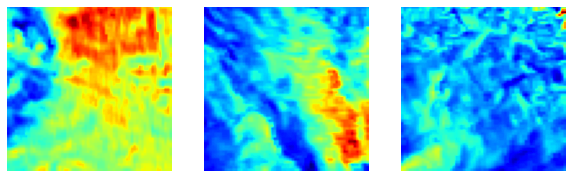

In [15]:
fig = show(outputs[:3])

Epoch 1/50


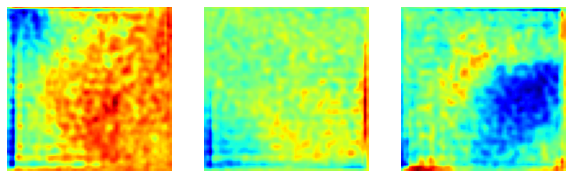

68/68 [==============================] - 396s 4s/step - d_loss: -84.1518 - g_loss: 30.9925 - d_gradient_pen: 1.4095 - g_gradient_param: 4.7191 - d_gradient_param: 314.2210 - d_fake: -16.6442 - d_real: 38.2780 - g_root_mean_squared_error: 2.5686 - g_lsd: 21.7722 - g_extreme_rmse: 1.5776 - g_ws_weighted_rmse: 5.4138 - g_spatial_ks: 0.7458 - g_acd: 0.4878 - val_loss: -119.7450 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 2/50


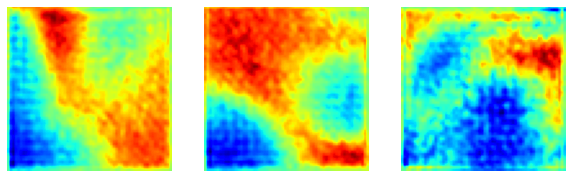

68/68 [==============================] - 297s 4s/step - d_loss: -202.4445 - g_loss: 99.4632 - d_gradient_pen: 2.6567 - g_gradient_param: 4.2687 - d_gradient_param: 674.1309 - d_fake: -89.7297 - d_real: 91.4680 - g_root_mean_squared_error: 2.6259 - g_lsd: 16.2248 - g_extreme_rmse: 1.5268 - g_ws_weighted_rmse: 4.7520 - g_spatial_ks: 0.7276 - g_acd: 0.4747 - val_loss: -118.4109 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 3/50


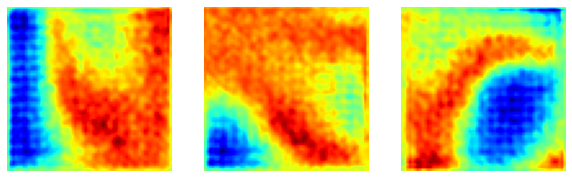

68/68 [==============================] - 297s 4s/step - d_loss: -298.6718 - g_loss: 146.0786 - d_gradient_pen: 4.8631 - g_gradient_param: 5.3990 - d_gradient_param: 7550.3498 - d_fake: -130.0675 - d_real: 136.9512 - g_root_mean_squared_error: 2.7865 - g_lsd: 14.1554 - g_extreme_rmse: 1.5526 - g_ws_weighted_rmse: 4.5481 - g_spatial_ks: 0.7201 - g_acd: 0.4727 - val_loss: -204.4530 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 4/50


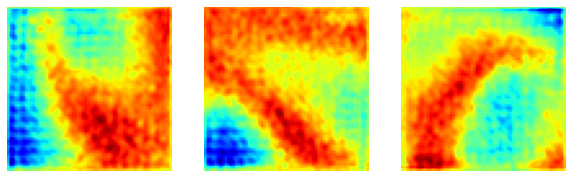

68/68 [==============================] - 298s 4s/step - d_loss: -385.9114 - g_loss: 186.6922 - d_gradient_pen: 6.9498 - g_gradient_param: 34.2400 - d_gradient_param: 9275.4474 - d_fake: -182.1512 - d_real: 185.8458 - g_root_mean_squared_error: 2.9001 - g_lsd: 13.2058 - g_extreme_rmse: 1.5762 - g_ws_weighted_rmse: 4.4575 - g_spatial_ks: 0.7159 - g_acd: 0.4743 - val_loss: -455.6797 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 5/50


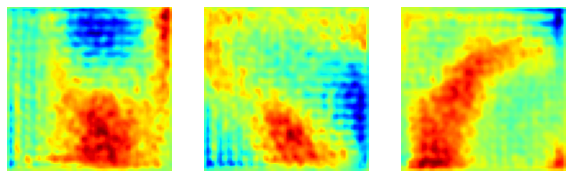

68/68 [==============================] - 303s 4s/step - d_loss: -519.0911 - g_loss: 253.6895 - d_gradient_pen: 11.6005 - g_gradient_param: 25.9109 - d_gradient_param: 15246.5635 - d_fake: -246.6589 - d_real: 252.6151 - g_root_mean_squared_error: 2.9557 - g_lsd: 12.6344 - g_extreme_rmse: 1.5804 - g_ws_weighted_rmse: 4.4111 - g_spatial_ks: 0.7106 - g_acd: 0.4746 - val_loss: -325.8223 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 6/50


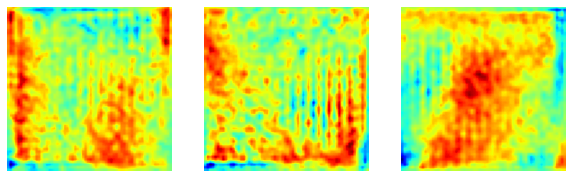

68/68 [==============================] - 298s 4s/step - d_loss: -641.0105 - g_loss: 308.5750 - d_gradient_pen: 16.2551 - g_gradient_param: 42.2964 - d_gradient_param: 17345.5896 - d_fake: -306.6605 - d_real: 308.5405 - g_root_mean_squared_error: 2.9835 - g_lsd: 12.2302 - g_extreme_rmse: 1.5818 - g_ws_weighted_rmse: 4.3616 - g_spatial_ks: 0.7062 - g_acd: 0.4745 - val_loss: -320.0961 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 7/50


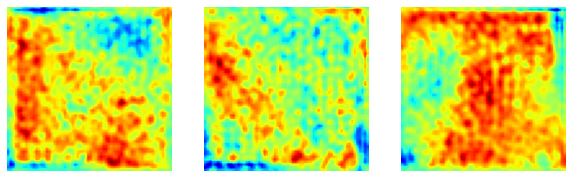

68/68 [==============================] - 304s 4s/step - d_loss: -790.4595 - g_loss: 394.6032 - d_gradient_pen: 18.7572 - g_gradient_param: 47.2127 - d_gradient_param: 33148.8040 - d_fake: -385.3035 - d_real: 380.3431 - g_root_mean_squared_error: 3.0389 - g_lsd: 11.9206 - g_extreme_rmse: 1.5954 - g_ws_weighted_rmse: 4.3487 - g_spatial_ks: 0.7050 - g_acd: 0.4752 - val_loss: -910.6371 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 8/50


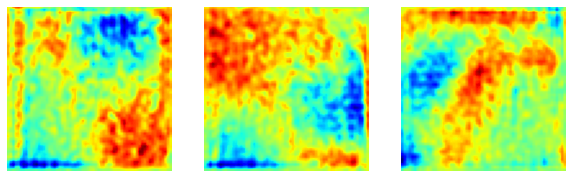

68/68 [==============================] - 314s 5s/step - d_loss: -929.9632 - g_loss: 442.5005 - d_gradient_pen: 30.5298 - g_gradient_param: 106.4763 - d_gradient_param: 103969.0574 - d_fake: -443.5003 - d_real: 464.7499 - g_root_mean_squared_error: 3.0565 - g_lsd: 11.6813 - g_extreme_rmse: 1.5983 - g_ws_weighted_rmse: 4.3332 - g_spatial_ks: 0.7026 - g_acd: 0.4753 - val_loss: -681.7798 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 9/50


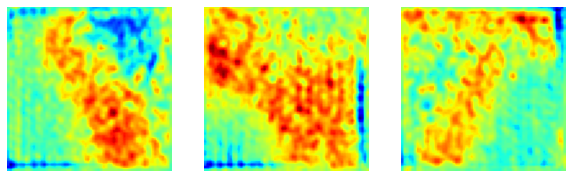

68/68 [==============================] - 296s 4s/step - d_loss: -1103.1114 - g_loss: 531.2778 - d_gradient_pen: 37.9789 - g_gradient_param: 38.4925 - d_gradient_param: 347527.4636 - d_fake: -533.9312 - d_real: 554.7119 - g_root_mean_squared_error: 3.0567 - g_lsd: 11.5099 - g_extreme_rmse: 1.6006 - g_ws_weighted_rmse: 4.3259 - g_spatial_ks: 0.6994 - g_acd: 0.4752 - val_loss: -611.0850 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 10/50


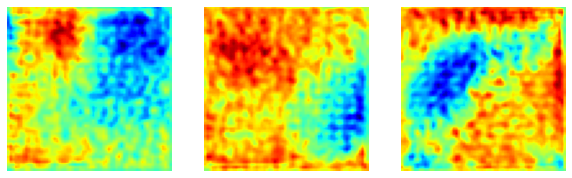

68/68 [==============================] - 297s 4s/step - d_loss: -1294.8644 - g_loss: 626.9642 - d_gradient_pen: 43.4412 - g_gradient_param: 78.4440 - d_gradient_param: 137033.2583 - d_fake: -622.5897 - d_real: 649.1696 - g_root_mean_squared_error: 3.0740 - g_lsd: 11.3567 - g_extreme_rmse: 1.6006 - g_ws_weighted_rmse: 4.3013 - g_spatial_ks: 0.6984 - g_acd: 0.4747 - val_loss: -1466.6664 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 11/50


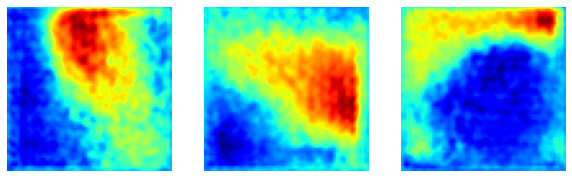

68/68 [==============================] - 296s 4s/step - d_loss: -1486.5974 - g_loss: 722.1257 - d_gradient_pen: 50.6695 - g_gradient_param: 171.0175 - d_gradient_param: 99161.1701 - d_fake: -665.9993 - d_real: 737.3108 - g_root_mean_squared_error: 3.0976 - g_lsd: 11.2556 - g_extreme_rmse: 1.6058 - g_ws_weighted_rmse: 4.2908 - g_spatial_ks: 0.6989 - g_acd: 0.4742 - val_loss: -1413.4192 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 12/50


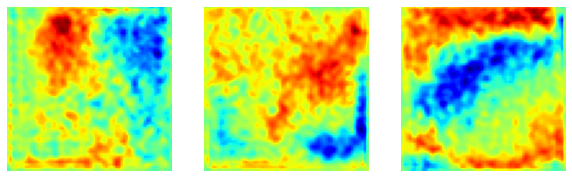

68/68 [==============================] - 296s 4s/step - d_loss: -1722.0836 - g_loss: 850.4097 - d_gradient_pen: 92.1814 - g_gradient_param: 498.4772 - d_gradient_param: 157603.0900 - d_fake: -817.1529 - d_real: 838.7700 - g_root_mean_squared_error: 3.1127 - g_lsd: 11.1636 - g_extreme_rmse: 1.6103 - g_ws_weighted_rmse: 4.2824 - g_spatial_ks: 0.6989 - g_acd: 0.4750 - val_loss: -1900.4681 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 13/50


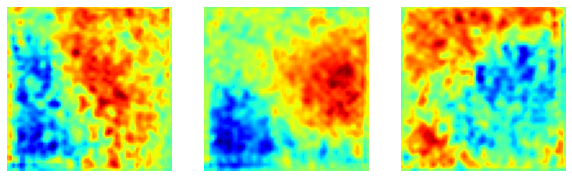

68/68 [==============================] - 297s 4s/step - d_loss: -1954.8678 - g_loss: 959.1375 - d_gradient_pen: 77.6726 - g_gradient_param: 387.0179 - d_gradient_param: 465391.0855 - d_fake: -911.7912 - d_real: 963.4648 - g_root_mean_squared_error: 3.1151 - g_lsd: 11.1041 - g_extreme_rmse: 1.6128 - g_ws_weighted_rmse: 4.2878 - g_spatial_ks: 0.6980 - g_acd: 0.4747 - val_loss: -1028.5579 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 14/50


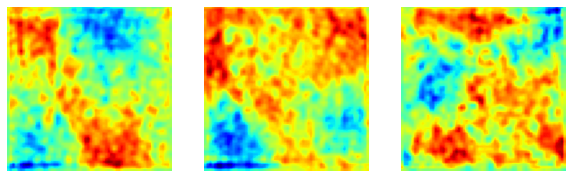

68/68 [==============================] - 296s 4s/step - d_loss: -2158.0028 - g_loss: 1061.1979 - d_gradient_pen: 125.4266 - g_gradient_param: 358.6667 - d_gradient_param: 2456089.2334 - d_fake: -1026.3788 - d_real: 1075.5849 - g_root_mean_squared_error: 3.1159 - g_lsd: 11.0613 - g_extreme_rmse: 1.6129 - g_ws_weighted_rmse: 4.2803 - g_spatial_ks: 0.6973 - g_acd: 0.4749 - val_loss: -820.0479 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 15/50


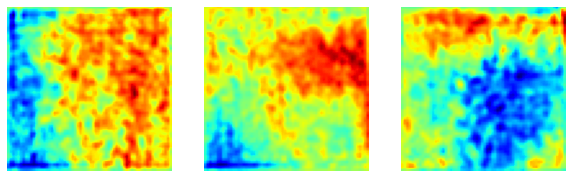

68/68 [==============================] - 294s 4s/step - d_loss: -2359.2826 - g_loss: 1176.6119 - d_gradient_pen: 157.3442 - g_gradient_param: 164.4393 - d_gradient_param: 1464774.7829 - d_fake: -1124.4186 - d_real: 1122.9227 - g_root_mean_squared_error: 3.1148 - g_lsd: 11.0226 - g_extreme_rmse: 1.6136 - g_ws_weighted_rmse: 4.2792 - g_spatial_ks: 0.6970 - g_acd: 0.4752 - val_loss: -1830.5715 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 16/50


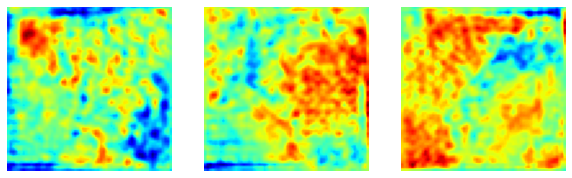

68/68 [==============================] - 294s 4s/step - d_loss: -2653.4801 - g_loss: 1311.6223 - d_gradient_pen: 168.9867 - g_gradient_param: 776.0776 - d_gradient_param: 929174.3537 - d_fake: -1272.2973 - d_real: 1287.6582 - g_root_mean_squared_error: 3.1105 - g_lsd: 10.9817 - g_extreme_rmse: 1.6134 - g_ws_weighted_rmse: 4.2779 - g_spatial_ks: 0.6962 - g_acd: 0.4749 - val_loss: -2478.9473 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 17/50


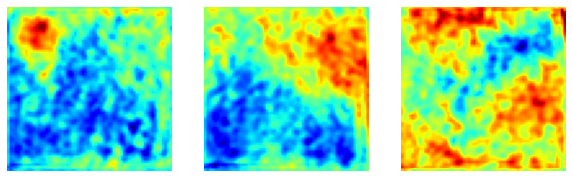

68/68 [==============================] - 299s 4s/step - d_loss: -2913.5608 - g_loss: 1435.8264 - d_gradient_pen: 219.9318 - g_gradient_param: 359.6338 - d_gradient_param: 1814627.9303 - d_fake: -1376.0666 - d_real: 1430.9706 - g_root_mean_squared_error: 3.1076 - g_lsd: 10.9563 - g_extreme_rmse: 1.6121 - g_ws_weighted_rmse: 4.2745 - g_spatial_ks: 0.6961 - g_acd: 0.4749 - val_loss: -1631.6169 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 18/50


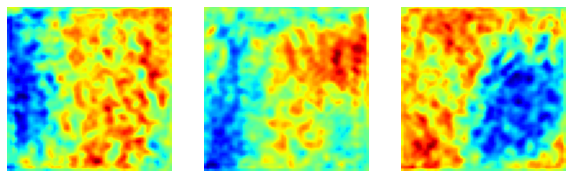

68/68 [==============================] - 301s 4s/step - d_loss: -3209.8521 - g_loss: 1566.4270 - d_gradient_pen: 304.5822 - g_gradient_param: 278.9114 - d_gradient_param: 1445882.0553 - d_fake: -1494.1649 - d_real: 1599.2177 - g_root_mean_squared_error: 3.1097 - g_lsd: 10.9298 - g_extreme_rmse: 1.6120 - g_ws_weighted_rmse: 4.2712 - g_spatial_ks: 0.6958 - g_acd: 0.4745 - val_loss: -2803.8167 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 19/50


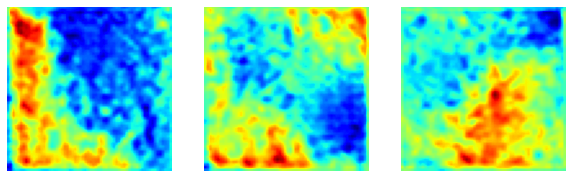

68/68 [==============================] - 298s 4s/step - d_loss: -3544.0474 - g_loss: 1745.0392 - d_gradient_pen: 413.5357 - g_gradient_param: 576.6778 - d_gradient_param: 2102965.1288 - d_fake: -1701.7712 - d_real: 1777.8834 - g_root_mean_squared_error: 3.1209 - g_lsd: 10.8933 - g_extreme_rmse: 1.6144 - g_ws_weighted_rmse: 4.2689 - g_spatial_ks: 0.6963 - g_acd: 0.4747 - val_loss: -2501.6257 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 20/50


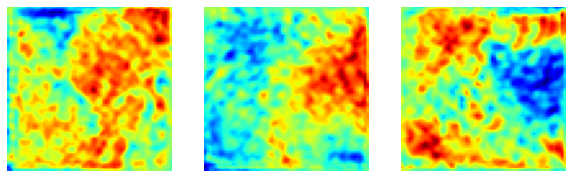

68/68 [==============================] - 296s 4s/step - d_loss: -3895.0864 - g_loss: 1950.7420 - d_gradient_pen: 434.8441 - g_gradient_param: 524.9800 - d_gradient_param: 2637906.1039 - d_fake: -1862.7943 - d_real: 1880.3868 - g_root_mean_squared_error: 3.1313 - g_lsd: 10.8715 - g_extreme_rmse: 1.6168 - g_ws_weighted_rmse: 4.2697 - g_spatial_ks: 0.6969 - g_acd: 0.4745 - val_loss: -2931.4639 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 21/50


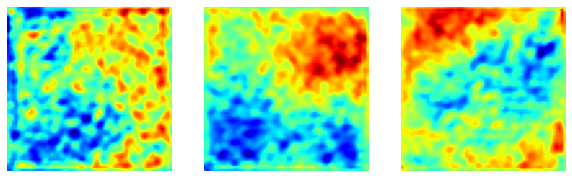

68/68 [==============================] - 297s 4s/step - d_loss: -4232.0215 - g_loss: 2142.1292 - d_gradient_pen: 547.9100 - g_gradient_param: 15.8673 - d_gradient_param: 2707316.2543 - d_fake: -2097.4664 - d_real: 2056.7238 - g_root_mean_squared_error: 3.1383 - g_lsd: 10.8588 - g_extreme_rmse: 1.6181 - g_ws_weighted_rmse: 4.2681 - g_spatial_ks: 0.6973 - g_acd: 0.4744 - val_loss: -4179.9819 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 22/50


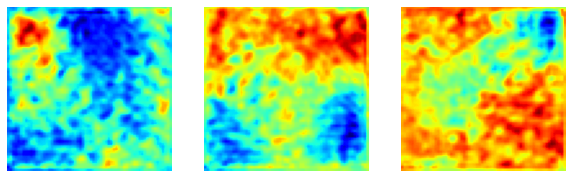

68/68 [==============================] - 296s 4s/step - d_loss: -4557.7082 - g_loss: 2273.3827 - d_gradient_pen: 724.3650 - g_gradient_param: 252.6499 - d_gradient_param: 2105078.0121 - d_fake: -2201.6766 - d_real: 2213.9566 - g_root_mean_squared_error: 3.1402 - g_lsd: 10.8452 - g_extreme_rmse: 1.6188 - g_ws_weighted_rmse: 4.2680 - g_spatial_ks: 0.6971 - g_acd: 0.4742 - val_loss: -3926.1467 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 23/50


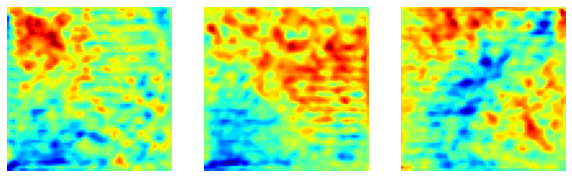

68/68 [==============================] - 296s 4s/step - d_loss: -4929.0192 - g_loss: 2464.2994 - d_gradient_pen: 710.0595 - g_gradient_param: 215.0660 - d_gradient_param: 4848911.1428 - d_fake: -2371.3241 - d_real: 2421.5212 - g_root_mean_squared_error: 3.1367 - g_lsd: 10.8271 - g_extreme_rmse: 1.6188 - g_ws_weighted_rmse: 4.2676 - g_spatial_ks: 0.6960 - g_acd: 0.4744 - val_loss: -4638.4971 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 24/50


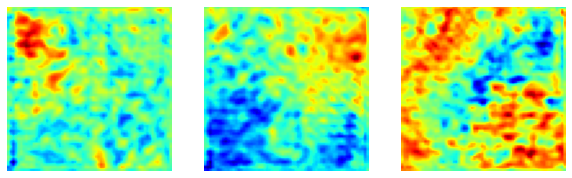

68/68 [==============================] - 294s 4s/step - d_loss: -5343.6374 - g_loss: 2660.2447 - d_gradient_pen: 699.9400 - g_gradient_param: 276.2121 - d_gradient_param: 3294582.1288 - d_fake: -2626.7380 - d_real: 2651.6769 - g_root_mean_squared_error: 3.1310 - g_lsd: 10.8151 - g_extreme_rmse: 1.6182 - g_ws_weighted_rmse: 4.2680 - g_spatial_ks: 0.6946 - g_acd: 0.4745 - val_loss: -5598.4106 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 25/50


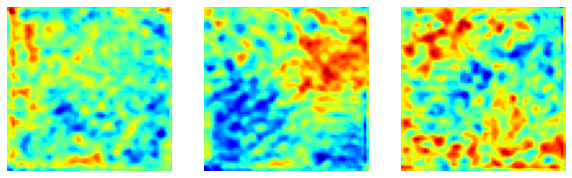

68/68 [==============================] - 295s 4s/step - d_loss: -5683.5634 - g_loss: 2868.7228 - d_gradient_pen: 724.8826 - g_gradient_param: 255.8692 - d_gradient_param: 21071298.1418 - d_fake: -2849.6094 - d_real: 2810.7104 - g_root_mean_squared_error: 3.1268 - g_lsd: 10.7963 - g_extreme_rmse: 1.6170 - g_ws_weighted_rmse: 4.2698 - g_spatial_ks: 0.6934 - g_acd: 0.4743 - val_loss: -5932.9580 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 26/50


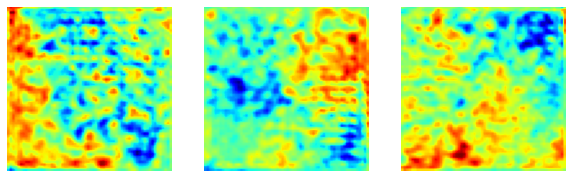

68/68 [==============================] - 295s 4s/step - d_loss: -6090.1403 - g_loss: 3071.8839 - d_gradient_pen: 923.1982 - g_gradient_param: 22.1653 - d_gradient_param: 12826348.1407 - d_fake: -3018.3273 - d_real: 2961.5504 - g_root_mean_squared_error: 3.1206 - g_lsd: 10.7732 - g_extreme_rmse: 1.6145 - g_ws_weighted_rmse: 4.2669 - g_spatial_ks: 0.6920 - g_acd: 0.4736 - val_loss: -5699.1821 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 27/50


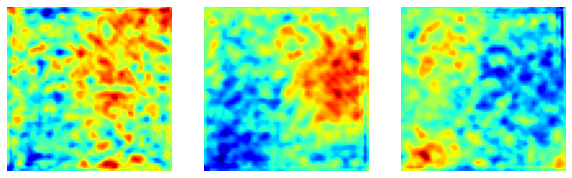

68/68 [==============================] - 295s 4s/step - d_loss: -6438.6305 - g_loss: 3210.4099 - d_gradient_pen: 1014.0147 - g_gradient_param: 343.3123 - d_gradient_param: 12816648.6081 - d_fake: -3159.2029 - d_real: 3123.5715 - g_root_mean_squared_error: 3.1211 - g_lsd: 10.7465 - g_extreme_rmse: 1.6141 - g_ws_weighted_rmse: 4.2671 - g_spatial_ks: 0.6910 - g_acd: 0.4734 - val_loss: -6804.0078 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 28/50


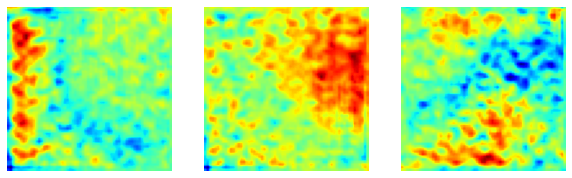

68/68 [==============================] - 294s 4s/step - d_loss: -6886.7854 - g_loss: 3433.9663 - d_gradient_pen: 1101.2542 - g_gradient_param: 122.1824 - d_gradient_param: 12761946.6490 - d_fake: -3307.7131 - d_real: 3369.6349 - g_root_mean_squared_error: 3.1175 - g_lsd: 10.7251 - g_extreme_rmse: 1.6130 - g_ws_weighted_rmse: 4.2675 - g_spatial_ks: 0.6898 - g_acd: 0.4733 - val_loss: -7251.2109 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 29/50


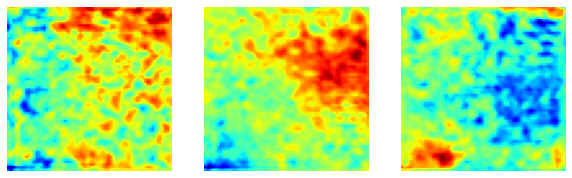

68/68 [==============================] - 294s 4s/step - d_loss: -7419.8713 - g_loss: 3705.5422 - d_gradient_pen: 1134.3531 - g_gradient_param: 13.8459 - d_gradient_param: 7241267.7610 - d_fake: -3658.6102 - d_real: 3653.2061 - g_root_mean_squared_error: 3.1089 - g_lsd: 10.7057 - g_extreme_rmse: 1.6098 - g_ws_weighted_rmse: 4.2662 - g_spatial_ks: 0.6884 - g_acd: 0.4729 - val_loss: -7713.0166 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 30/50


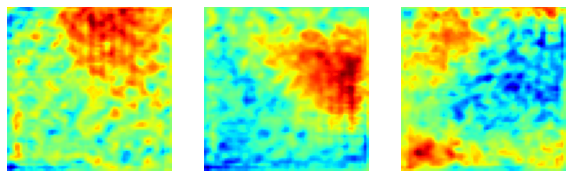

68/68 [==============================] - 295s 4s/step - d_loss: -7767.8829 - g_loss: 3850.2546 - d_gradient_pen: 1049.0529 - g_gradient_param: 2077.2372 - d_gradient_param: 9839905.1282 - d_fake: -3741.1798 - d_real: 3811.1386 - g_root_mean_squared_error: 3.1031 - g_lsd: 10.6849 - g_extreme_rmse: 1.6080 - g_ws_weighted_rmse: 4.2661 - g_spatial_ks: 0.6872 - g_acd: 0.4728 - val_loss: -7991.4028 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 31/50


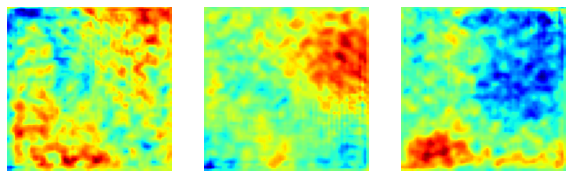

68/68 [==============================] - 295s 4s/step - d_loss: -8164.4249 - g_loss: 3990.2689 - d_gradient_pen: 929.5442 - g_gradient_param: 1927.4997 - d_gradient_param: 23362355.2420 - d_fake: -3768.1436 - d_real: 4126.0296 - g_root_mean_squared_error: 3.1025 - g_lsd: 10.6589 - g_extreme_rmse: 1.6059 - g_ws_weighted_rmse: 4.2640 - g_spatial_ks: 0.6869 - g_acd: 0.4725 - val_loss: -7936.4268 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 32/50


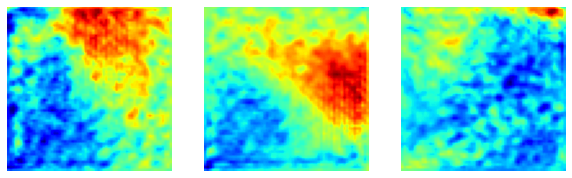

68/68 [==============================] - 294s 4s/step - d_loss: -8729.0656 - g_loss: 4369.1178 - d_gradient_pen: 1135.8228 - g_gradient_param: 858.8720 - d_gradient_param: 10977715.1756 - d_fake: -4284.0275 - d_real: 4282.8158 - g_root_mean_squared_error: 3.0987 - g_lsd: 10.6381 - g_extreme_rmse: 1.6043 - g_ws_weighted_rmse: 4.2643 - g_spatial_ks: 0.6862 - g_acd: 0.4722 - val_loss: -9088.9590 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 33/50


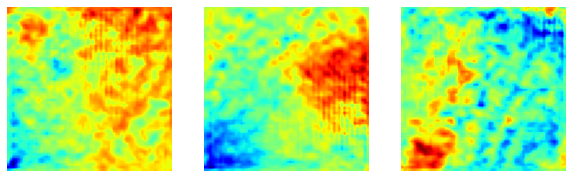

68/68 [==============================] - 295s 4s/step - d_loss: -9208.7633 - g_loss: 4595.4260 - d_gradient_pen: 1289.6676 - g_gradient_param: 1410.6650 - d_gradient_param: 7720603.4145 - d_fake: -4564.7219 - d_real: 4610.7588 - g_root_mean_squared_error: 3.0928 - g_lsd: 10.6161 - g_extreme_rmse: 1.6029 - g_ws_weighted_rmse: 4.2637 - g_spatial_ks: 0.6852 - g_acd: 0.4721 - val_loss: -8842.1484 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 34/50


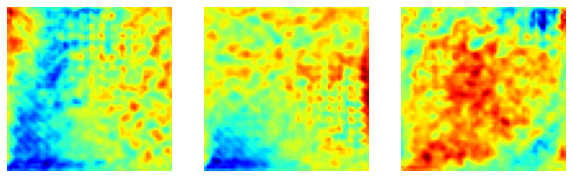

68/68 [==============================] - 295s 4s/step - d_loss: -9753.7399 - g_loss: 4873.8846 - d_gradient_pen: 1487.9459 - g_gradient_param: 86.8776 - d_gradient_param: 14697220.2675 - d_fake: -4840.3961 - d_real: 4832.5124 - g_root_mean_squared_error: 3.0885 - g_lsd: 10.5925 - g_extreme_rmse: 1.6017 - g_ws_weighted_rmse: 4.2617 - g_spatial_ks: 0.6843 - g_acd: 0.4721 - val_loss: -10060.2959 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 35/50


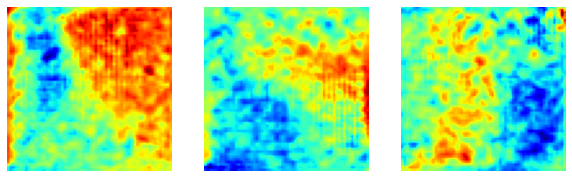

68/68 [==============================] - 294s 4s/step - d_loss: -10254.0816 - g_loss: 5054.7373 - d_gradient_pen: 1523.2906 - g_gradient_param: 1579.4039 - d_gradient_param: 3358337.1467 - d_fake: -4941.2829 - d_real: 5126.3099 - g_root_mean_squared_error: 3.0924 - g_lsd: 10.5729 - g_extreme_rmse: 1.6043 - g_ws_weighted_rmse: 4.2644 - g_spatial_ks: 0.6842 - g_acd: 0.4725 - val_loss: -10662.8125 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 36/50


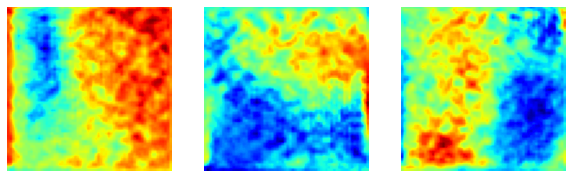

68/68 [==============================] - 293s 4s/step - d_loss: -10605.8518 - g_loss: 5278.2903 - d_gradient_pen: 1312.1609 - g_gradient_param: 3483.2276 - d_gradient_param: 8597127.6219 - d_fake: -5171.1461 - d_real: 5237.5728 - g_root_mean_squared_error: 3.0986 - g_lsd: 10.5567 - g_extreme_rmse: 1.6067 - g_ws_weighted_rmse: 4.2657 - g_spatial_ks: 0.6847 - g_acd: 0.4728 - val_loss: -11062.3691 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 37/50


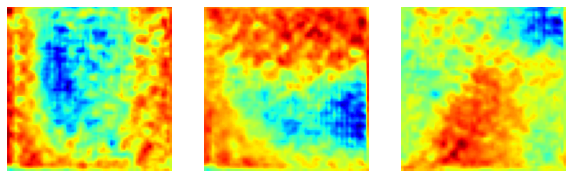

68/68 [==============================] - 295s 4s/step - d_loss: -11301.3996 - g_loss: 5636.6019 - d_gradient_pen: 1612.7386 - g_gradient_param: 388.8505 - d_gradient_param: 5492704.1516 - d_fake: -5604.7784 - d_real: 5610.6336 - g_root_mean_squared_error: 3.0987 - g_lsd: 10.5407 - g_extreme_rmse: 1.6067 - g_ws_weighted_rmse: 4.2660 - g_spatial_ks: 0.6846 - g_acd: 0.4726 - val_loss: -4526.7266 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 38/50


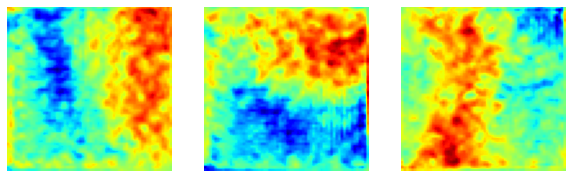

68/68 [==============================] - 295s 4s/step - d_loss: -11742.3571 - g_loss: 5882.8049 - d_gradient_pen: 1965.0969 - g_gradient_param: 818.7655 - d_gradient_param: 29990616.4739 - d_fake: -5792.6079 - d_real: 5716.9938 - g_root_mean_squared_error: 3.0987 - g_lsd: 10.5254 - g_extreme_rmse: 1.6066 - g_ws_weighted_rmse: 4.2630 - g_spatial_ks: 0.6846 - g_acd: 0.4725 - val_loss: -12252.7773 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 39/50


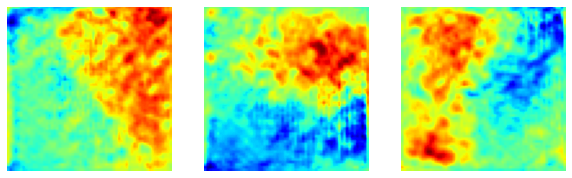

68/68 [==============================] - 294s 4s/step - d_loss: -12457.2326 - g_loss: 6218.8048 - d_gradient_pen: 1813.3594 - g_gradient_param: 3690.8296 - d_gradient_param: 15283625.6598 - d_fake: -6104.3007 - d_real: 6100.7145 - g_root_mean_squared_error: 3.0978 - g_lsd: 10.5101 - g_extreme_rmse: 1.6057 - g_ws_weighted_rmse: 4.2607 - g_spatial_ks: 0.6843 - g_acd: 0.4722 - val_loss: -12319.3926 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 40/50


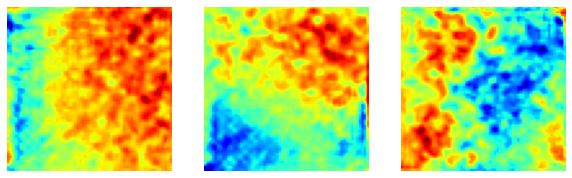

68/68 [==============================] - 293s 4s/step - d_loss: -12617.7308 - g_loss: 6225.9258 - d_gradient_pen: 1981.6675 - g_gradient_param: 184.2717 - d_gradient_param: 34968259.8545 - d_fake: -6263.7608 - d_real: 6364.5498 - g_root_mean_squared_error: 3.0988 - g_lsd: 10.4962 - g_extreme_rmse: 1.6064 - g_ws_weighted_rmse: 4.2618 - g_spatial_ks: 0.6843 - g_acd: 0.4723 - val_loss: -9277.4443 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 41/50


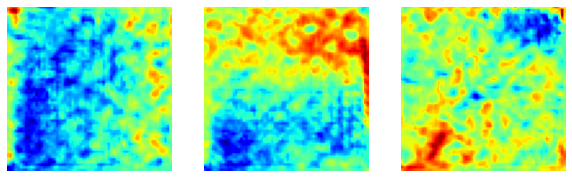

68/68 [==============================] - 305s 4s/step - d_loss: -13674.0409 - g_loss: 6766.2686 - d_gradient_pen: 1437.8720 - g_gradient_param: 8614.7710 - d_gradient_param: 4333860.6886 - d_fake: -6643.7608 - d_real: 6830.6540 - g_root_mean_squared_error: 3.0994 - g_lsd: 10.4815 - g_extreme_rmse: 1.6055 - g_ws_weighted_rmse: 4.2628 - g_spatial_ks: 0.6841 - g_acd: 0.4719 - val_loss: -14118.1436 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 42/50


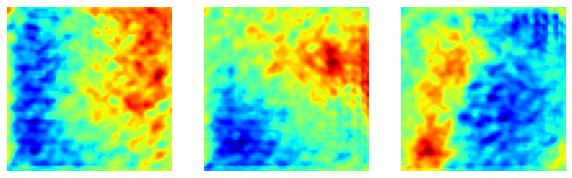

68/68 [==============================] - 301s 4s/step - d_loss: -14128.4488 - g_loss: 7022.0830 - d_gradient_pen: 1728.0948 - g_gradient_param: 1134.5196 - d_gradient_param: 15706449.2127 - d_fake: -6994.4146 - d_real: 7054.2193 - g_root_mean_squared_error: 3.1012 - g_lsd: 10.4693 - g_extreme_rmse: 1.6041 - g_ws_weighted_rmse: 4.2605 - g_spatial_ks: 0.6840 - g_acd: 0.4715 - val_loss: -14712.1777 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 43/50


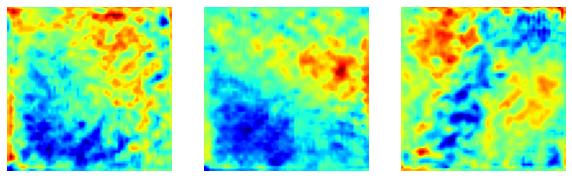

68/68 [==============================] - 293s 4s/step - d_loss: -14781.3568 - g_loss: 7303.2844 - d_gradient_pen: 2088.6807 - g_gradient_param: 6833.0414 - d_gradient_param: 7955429.3699 - d_fake: -7120.7390 - d_real: 7401.3039 - g_root_mean_squared_error: 3.1027 - g_lsd: 10.4582 - g_extreme_rmse: 1.6040 - g_ws_weighted_rmse: 4.2631 - g_spatial_ks: 0.6839 - g_acd: 0.4713 - val_loss: -15401.0918 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 44/50


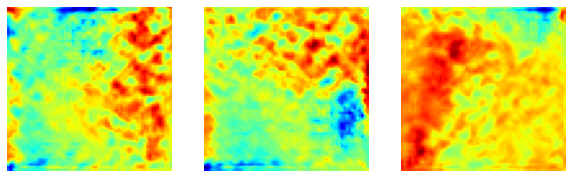

68/68 [==============================] - 293s 4s/step - d_loss: -15423.0148 - g_loss: 7627.4480 - d_gradient_pen: 1890.2149 - g_gradient_param: 9320.2192 - d_gradient_param: 22579585.8616 - d_fake: -7326.7178 - d_real: 7734.6821 - g_root_mean_squared_error: 3.1022 - g_lsd: 10.4502 - g_extreme_rmse: 1.6031 - g_ws_weighted_rmse: 4.2639 - g_spatial_ks: 0.6837 - g_acd: 0.4711 - val_loss: -12374.0234 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 45/50


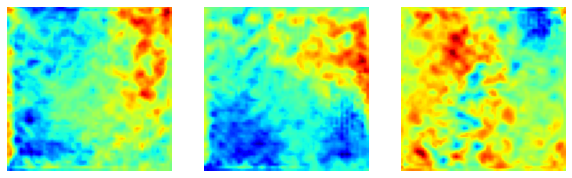

68/68 [==============================] - 293s 4s/step - d_loss: -15875.1547 - g_loss: 7744.3864 - d_gradient_pen: 2011.3897 - g_gradient_param: 34236.7951 - d_gradient_param: 13365052.3777 - d_fake: -7812.6421 - d_real: 8023.6976 - g_root_mean_squared_error: 3.1008 - g_lsd: 10.4415 - g_extreme_rmse: 1.6027 - g_ws_weighted_rmse: 4.2653 - g_spatial_ks: 0.6832 - g_acd: 0.4710 - val_loss: -12120.7812 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 46/50


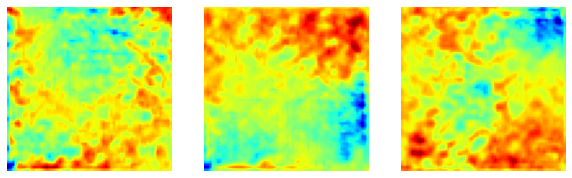

68/68 [==============================] - 293s 4s/step - d_loss: -16623.1343 - g_loss: 8169.8906 - d_gradient_pen: 1948.0433 - g_gradient_param: 2330.3723 - d_gradient_param: 28447103.3184 - d_fake: -8219.5426 - d_real: 8396.0510 - g_root_mean_squared_error: 3.1009 - g_lsd: 10.4323 - g_extreme_rmse: 1.6026 - g_ws_weighted_rmse: 4.2658 - g_spatial_ks: 0.6830 - g_acd: 0.4709 - val_loss: -15991.1201 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 47/50


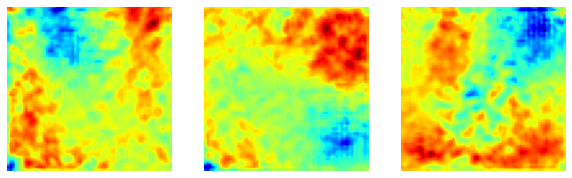

68/68 [==============================] - 302s 4s/step - d_loss: -17480.2945 - g_loss: 8687.6755 - d_gradient_pen: 2031.6970 - g_gradient_param: 8690.1711 - d_gradient_param: 9459123.6598 - d_fake: -8612.0300 - d_real: 8673.2583 - g_root_mean_squared_error: 3.1024 - g_lsd: 10.4257 - g_extreme_rmse: 1.6038 - g_ws_weighted_rmse: 4.2688 - g_spatial_ks: 0.6831 - g_acd: 0.4711 - val_loss: -15297.9795 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 48/50


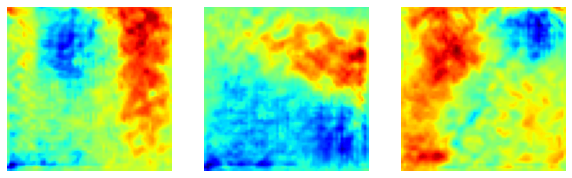

68/68 [==============================] - 293s 4s/step - d_loss: -18145.8024 - g_loss: 8990.9146 - d_gradient_pen: 2124.9616 - g_gradient_param: 3081.7382 - d_gradient_param: 17855013.4643 - d_fake: -8921.8117 - d_real: 9087.4093 - g_root_mean_squared_error: 3.1034 - g_lsd: 10.4199 - g_extreme_rmse: 1.6043 - g_ws_weighted_rmse: 4.2700 - g_spatial_ks: 0.6831 - g_acd: 0.4713 - val_loss: -12549.8223 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 49/50


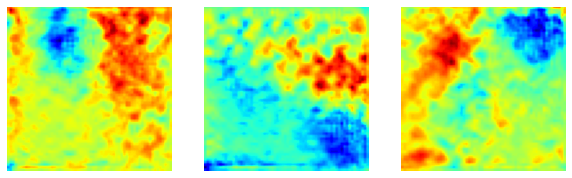

68/68 [==============================] - 293s 4s/step - d_loss: -18684.3368 - g_loss: 9163.9440 - d_gradient_pen: 1803.9610 - g_gradient_param: 8834.6698 - d_gradient_param: 17254161.6666 - d_fake: -9159.9421 - d_real: 9425.3779 - g_root_mean_squared_error: 3.1010 - g_lsd: 10.4138 - g_extreme_rmse: 1.6030 - g_ws_weighted_rmse: 4.2686 - g_spatial_ks: 0.6829 - g_acd: 0.4711 - val_loss: -17562.5547 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00
Epoch 50/50


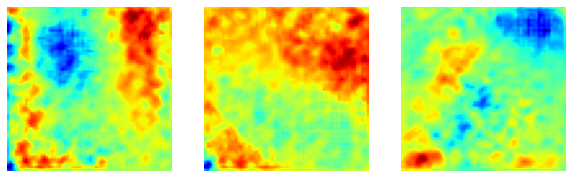

68/68 [==============================] - 293s 4s/step - d_loss: -19527.2833 - g_loss: 9646.0830 - d_gradient_pen: 1929.4892 - g_gradient_param: 2674.5347 - d_gradient_param: 18134388.9751 - d_fake: -9616.6558 - d_real: 9788.7636 - g_root_mean_squared_error: 3.0990 - g_lsd: 10.4059 - g_extreme_rmse: 1.6021 - g_ws_weighted_rmse: 4.2672 - g_spatial_ks: 0.6826 - g_acd: 0.4710 - val_loss: -20030.3047 - val_d_fake: 0.0000e+00 - val_d_real: 0.0000e+00


In [16]:
gan.fit(inputs, outputs, callbacks=callbacks, epochs=50, batch_size=BATCH_SIZE, validation_split=0.25, shuffle=True)